<img src='img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<hr>

# Copernicus Sentinel-3 SLSTR - Fire Radiative Power (FRP)

#### Load required libraries

In [9]:
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [10]:
%run functions.ipynb

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR FRP data

Sentinel-3 SLSTR NRT FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `xr.open_dataset()` function.


The data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

In [11]:
frp_dir = 'eodata/sentinel3/slstr/frp/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (fires: 63, rows: 1200, columns: 1500)
Dimensions without coordinates: fires, rows, columns
Data variables: (12/25)
    BT_MIR                  (fires) float64 ...
    BT_window               (fires) float64 ...
    Day_night               (fires) int8 ...
    F1_Fire_pixel_radiance  (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    ...                      ...
    n_cloud                 (fires) int16 ...
    n_water                 (fires) int16 ...
    n_window                (fires) int16 ...
    time                    (fires) datetime64[ns] ...
    transmittance_MWIR      (fires) float64 ...
    used_channel            (fires) uint8 ...
Attributes: (12/17)
    absolute_orbit_number:  32861
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20240816T224911Z
    history:                  2024-08-16T22:49:11Z: PUGCoreProcessor JobOrder...
    institution:            PS2
    ...                     ...
    source:                 IPF-SL-2-FRP 01.09
    start_offset:           15713
    start_time:             2024-08-16T08:03:53.087978Z
    stop_time:              2024-08-16T08:06:52.781549Z
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    track_offset:           998

#### Load `latitude` and `longitude` information

In [12]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (fires: 63)>
array([30.505073, 30.970367, 30.884256, 30.896045, 30.981618, 30.897834,
       30.910452, 36.392313, 36.403635, 33.451747, 34.591684, 28.125641,
       35.786422, 27.261089, 36.142898, 27.14972 , 27.16055 , 27.139204,
       36.106765, 27.09072 , 27.144927, 27.155435, 27.080292, 27.095397,
       27.161704, 30.314361, 35.570998, 30.665989, 30.447434, 30.466937,
       30.511074, 30.449405, 30.460825, 30.48033 , 30.49169 , 30.493628,
       30.961933, 30.974231, 30.932891, 30.944579, 30.957979, 30.926829,
       30.945526, 30.927396, 30.939591, 30.952611, 30.970171, 30.964616,
       34.579206, 34.589815, 34.602322, 28.120979, 35.775333, 35.797476,
       36.154084, 27.17298 , 27.182052, 27.150677, 30.30309 , 35.581918,
       30.655685, 30.669738, 30.676314])
Dimensions without coordinates: fires
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_max:      180.0
    valid_min:      -180.0

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `regridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [13]:
sampling_lat_FRP_grid = 0.01        # Sampling for gridded FRP values & difference  stats computation 
sampling_lon_FRP_grid = 0.01        # Sampling for gridded FRP values & difference  stats computation 
FRP_plot_max_grid     = 1000.         # Max Integrated FRP value, for plots


lat_min               = 38.        # Minimum latitude for mapping plot [deg N]
lat_max               = 39.        # Maximum latitude for mapping plot [deg N]
lon_min               = 26.        # Minimum longitude for mapping plot [deg E]
lon_max               = 28.        # Maximum longitude for mapping plot [deg E]

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. 63 fire occurrences were identified. This includes also FRP pixels with reduced quality. To retrieve the actual number of fires identified by the `MWIR channels`, we mask out non-valid pixels.

In [14]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 63)>
array([  11.158897,   96.089606,   39.552422,   21.044601,   17.934845,
        107.717565,   49.156813,   46.425707,    9.629629,   23.457015,
          9.361673,   31.126826,   12.261145,   28.771561,   16.593313,
         77.274919,  148.782785,  143.826228,    9.503562,  287.409412,
       1074.615424,  509.905453,  204.929362,   82.568169,  222.133027,
          9.894094,   31.133261,    7.480996,   13.308267,   12.4477  ,
          8.108549,    8.265498,   11.987971,   16.126518,   12.451029,
         11.182548,   19.354976,   10.683837,   10.763401,   11.784672,
         12.820006,   12.779444,   13.98827 ,   10.764225,   10.623246,
         17.751636,   11.526683,   17.498006,    5.057754,    4.699251,
          7.567932,   21.091483,    7.133776,    4.155411,    6.864647,
         53.52698 ,   27.203058,   32.868946,   10.740547,    5.977518,
          5.301394,    6.898466,    4.676404])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

The next step is to mask out FRP pixels with reduced quality. Valid pixels are different to -1. We use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to extract pixels of high quality.

A total of 63 fire occurrences were identified by the `MWIR channels`. Fires identified by the `MWIR channels - S7 and F1` detect fires with a temperature lower than 1100 Kelvin.

In [15]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 63)>
array([  11.15889682,   96.08960626,   39.55242211,   21.0446014 ,
         17.93484498,  107.7175648 ,   49.15681288,   46.42570669,
          9.6296289 ,   23.45701527,    9.36167315,   31.12682623,
         12.26114461,   28.77156074,   16.59331286,   77.2749191 ,
        148.78278481,  143.82622808,    9.5035623 ,  287.40941237,
       1074.61542415,  509.90545339,  204.92936228,   82.56816919,
        222.13302675,    9.894094  ,   31.1332612 ,    7.48099578,
         13.30826719,   12.44769976,    8.10854913,    8.26549827,
         11.98797118,   16.12651779,   12.45102908,   11.1825477 ,
         19.35497557,   10.68383738,   10.76340147,   11.78467168,
         12.82000628,   12.77944409,   13.98826973,   10.76422514,
         10.62324636,   17.75163592,   11.52668346,   17.49800577,
          5.05775437,    4.6992512 ,    7.56793197,   21.09148343,
          7.13377588,    4.15541051,    6.8646472 ,   53.52697987,
         27.20305779,   32.86894635,   10.74054742,    5.9775179 ,
          5.30139357,    6.89846639,    4.67640423])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

In [16]:
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_MWIR

63

### Generate a gridded FRP array

The loaded `xarray.DataArray` is a one-dimensional array (list) of the fire occurences that were identified. The next step is to combine the fire occurrences with the geographcial coordinates and to bring the information onto a regular grid to create gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.

In [17]:
def slstr_frp_gridding(parameter_array, 
                       parameter, 
                       lat_min, lat_max, lon_min, lon_max, 
                       sampling_lat_FRP_grid, 
                       sampling_lon_FRP_grid,
                       n_fire,
                       lat_frp,
                       lon_frp,
                       **kwargs):
    """ 
    Produces gridded data of Sentinel-3 SLSTR NRT Fire Radiative Power Data
    
    Parameters:
        parameter_array (xarray DataArray):
        parameter (str): NRT S3 FRP channel - either `mwir`, `swir` or `swir_nosaa`
        lat_min, lat_max, lon_min, lon_max(float): Floats of geographical bounding box
        sampling_lat_FRP_grid, sampling_long_FRP_grid(float): Float of grid cell size
        n_fire (int): Number of fire occurences
        lat_frp (xarray DataArray): Latitude values of occurred fire events
        lon_frp (xarray DataArray): Longitude values of occurred fire events
        **kwargs: additional keyword arguments to be added

    Returns:
        the gridded data array and latitude and longitude grid information
    """ 
    n_lat = int( (np.float32(lat_max) - np.float32(lat_min)) / sampling_lat_FRP_grid ) + 1 # Number of rows per latitude sampling
    n_lon = int( (np.float32(lon_max) - np.float32(lon_min)) / sampling_lon_FRP_grid ) + 1 # Number of lines per longitude sampling

    
    slstr_frp_gridded = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.

    lat_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    lon_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    
    if (n_fire >= 0):
    
    # Loop on i_lat: begins
        for i_lat in range(n_lat):
                    
        # Loop on i_lon: begins
            for i_lon in range(n_lon):
                        
                lat_grid[i_lat, i_lon] = lat_min + np.float32(i_lat) * sampling_lat_FRP_grid + sampling_lat_FRP_grid / 2.
                lon_grid[i_lat, i_lon] = lon_min + np.float32(i_lon) * sampling_lon_FRP_grid + sampling_lon_FRP_grid / 2.
                            
            # Gridded SLSTR FRP MWIR Night - All days
                if(parameter=='swir_nosaa'):
                    FLAG_FRP_SWIR_SAA_nc = kwargs.get('flag', None)
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.) & (FLAG_FRP_SWIR_SAA_nc[:] == 0), False, True)
                else:
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.),  False, True)
                            
                masked_slstr_frp_grid = np.ma.array(parameter_array[:], mask=mask_grid)
                            
                if len(masked_slstr_frp_grid.compressed()) != 0:
                    slstr_frp_gridded[i_lat, i_lon]  = np.sum(masked_slstr_frp_grid.compressed())
    return slstr_frp_gridded, lat_grid, lon_grid
    

Apply the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to the `frp_mwir` data array.

In [18]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir, 
                                                       parameter='mwir', 
                                                       lat_min=lat_min,
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[38.005, 38.005, 38.005, ..., 38.005, 38.005, 38.005],
        [38.015, 38.015, 38.015, ..., 38.015, 38.015, 38.015],
        [38.025, 38.025, 38.025, ..., 38.025, 38.025, 38.025],
        ...,
        [38.985, 38.985, 38.985, ..., 38.985, 38.985, 38.985],
        [38.995, 38.995, 38.995, ..., 38.995, 38.995, 38.995],
        [39.005, 39.005, 39.005, ..., 39.005, 39.005, 39.005]],
       dtype=float32),
 array([[26.005, 26.015, 26.025, ..., 27.985, 27.995, 28.005],
        [26.005, 26.015, 26.025, ..., 27.985, 27.995, 28.005],
        [26.005, 26.015, 26.025, ..., 27.985

Mask out the invalid pixels (pixels that are equal to -9999.) for plotting. We use numpy's function `np.ma.masked_array()` for this.

In [19]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Calculate some statistics and add them to a string in order to integrate the information with the final plot.

In [20]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)

FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



### Visualize the masked data array with matplotlib's `pcolormesh()` function

Let us create a function called [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) which makes use of matplotlib's `pcolormesh` function and `Cartopy` and integrates the text information created above into the plot.

In [21]:
def visualize_s3_frp(data, lat, lon, unit, longname, textstr_1, textstr_2, vmax):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function.
    
    Parameters:
        data (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        lat (numpy Array): array with longitude values
        lon (numpy Array) : array with latitude values
        unit (str): unit of the resulting plot
        longname (str): Longname to be used as title
        textstr_1 (str): String to fill box 1
        textstr_2 (str): String to fill box 2
        vmax (float): Maximum value of color scale
    """    
    fig=plt.figure(figsize=(20, 15))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(lon, lat, data, 
                        cmap=cm.autumn_r, transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=vmax)

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.bottom_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.029, pad=0.025)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(longname, fontsize=20, pad=40.0) 

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box on the right side of the plot
    ax.text(1.1, 0.9, textstr_1, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.1, 0.85, textstr_2, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    plt.show()

                                

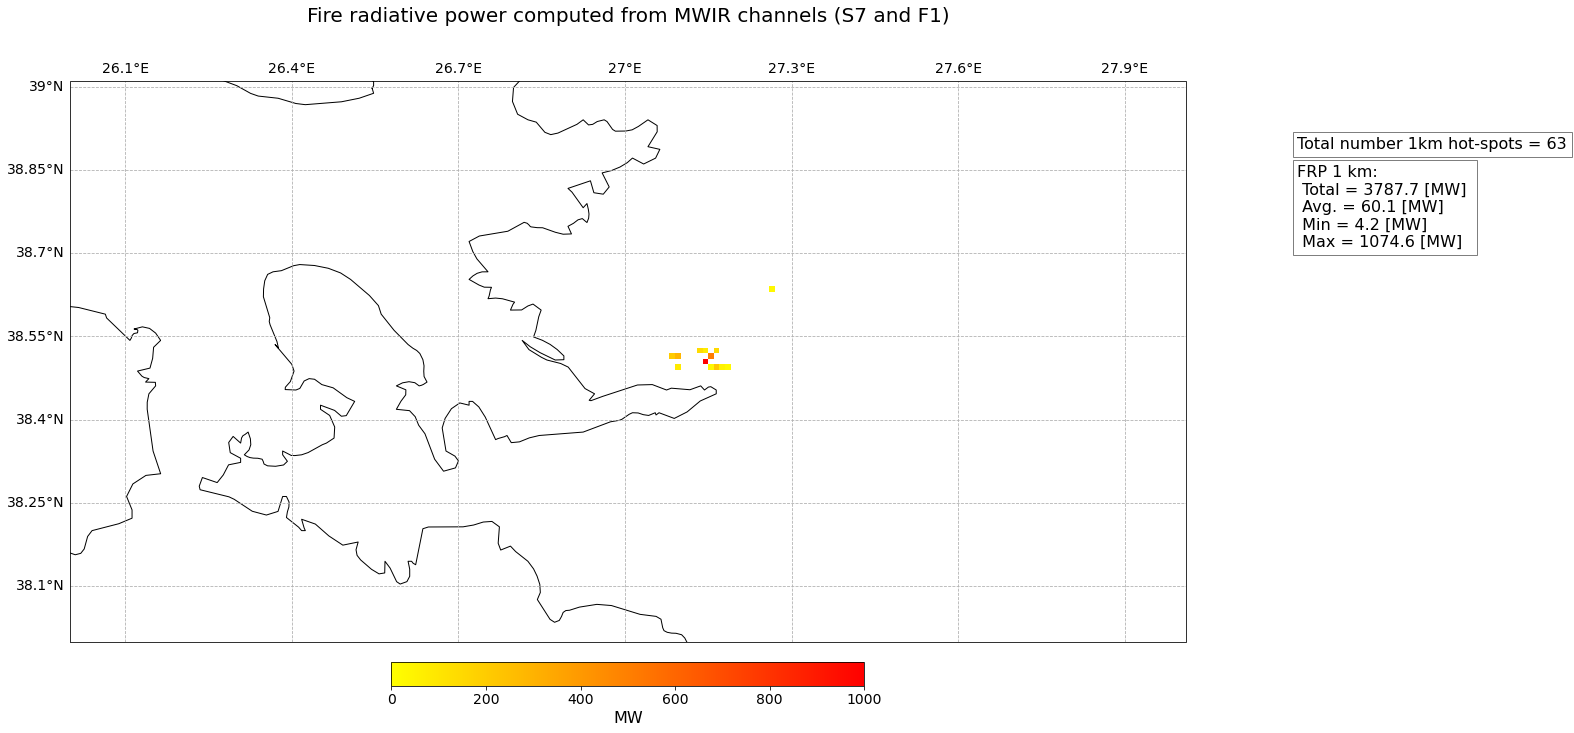

In [22]:
long_name = frp_mwir.long_name
unit = frp_mwir.units

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<hr>

<p><img src='img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>